# Advanced AI Text Detection - Complete Training Pipeline (Google Colab)

This notebook is optimized for Google Colab and implements a comprehensive training pipeline for AI text detection, optimized to achieve 99%+ accuracy.

**Features:**
- All utilities included inline (no external files needed)
- File upload widget for dataset
- Optimized feature engineering (word + character n-grams)
- Extensive hyperparameter tuning
- Cross-validation for robust evaluation
- Multiple model comparison
- Comprehensive visualizations
- Model download functionality


In [1]:
# Install required packages (Colab may not have all)
%pip install -q scikit-learn scipy pandas matplotlib seaborn

print("✓ Packages installed!")


✓ Packages installed!


In [5]:
# Import all necessary libraries
import json
import os
import sys
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple, Any
from collections import Counter
from time import time
from google.colab import files
import io

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    StratifiedKFold,
    learning_curve
)
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    f1_score
)
from sklearn.utils import shuffle
from scipy.sparse import hstack
import re

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
RANDOM_STATE = 42

print("✓ All libraries imported successfully!")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")


✓ All libraries imported successfully!
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy version: 2.0.2


## Utility Functions (Included for Colab)


In [6]:
# Include all utility functions inline for Colab
def clean_text(text: str) -> str:
    """Advanced text cleaning for AI detection."""
    if not isinstance(text, str):
        return ""

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove non-breaking spaces and special unicode
    text = text.replace('\xa0', ' ')
    text = text.replace('\u200b', '')
    text = text.replace('\u200c', '')
    text = text.replace('\u200d', '')

    # Remove excessive punctuation
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[.]{3,}', '...', text)

    return text.strip()

print("✓ Utility functions defined")


✓ Utility functions defined


## 1. Upload and Load Dataset


In [7]:
# Upload dataset file
print("=" * 70)
print("UPLOAD DATASET")
print("=" * 70)
print("Please upload your 'combined_dataset_clean.json' file:")
uploaded = files.upload()

# Get the uploaded file
if uploaded:
    filename = list(uploaded.keys())[0]
    print(f"\n✓ File uploaded: {filename}")

    # Load the dataset
    dataset = json.loads(uploaded[filename].decode('utf-8'))
    print(f"✓ Loaded {len(dataset):,} articles")

    # Display sample
    if len(dataset) > 0:
        print("\nSample article:")
        print(json.dumps(dataset[0], indent=2, ensure_ascii=False))
else:
    raise ValueError("No file uploaded! Please upload combined_dataset_clean.json")


UPLOAD DATASET
Please upload your 'combined_dataset_clean.json' file:


Saving combined_dataset_clean.json to combined_dataset_clean.json

✓ File uploaded: combined_dataset_clean.json
✓ Loaded 10,000 articles

Sample article:
{
  "content": "Yunanıstanda \"Qərbi Nil\" qızdırması ilə bağlı narahat edici xəbərlər yayılır! 27 nəfər bu virus səbəbi ilə həyatını itirib. Xəstəliklərə nəzarət və profilaktika Mərkəzindən gələn məlumata görə, bu virusun yoluxması mərkəzi əsəb sisteminin pozulması ilə nəticələnir. Avqustun 23-ü ərəfəsində 103 yeni yoluxma halları qeydə alınıb və bunlardan 11-i ölümlə nəticələnib. Yunanıstanda bu virusun ilk dəfə aşkarlanması 2010-cu ildə olub və o zamandan bəri 80 nəfər qurban verib. Bu virus ağcaqanadlar aracılığı ilə yayılır və ciddi təhlükə yaradır. Bu məsələ ilə bağlı diqqətli olmaq və tədbirlərə diqqət etmək əhəmiyyətli məsələdir.",
  "label": "ai"
}


## 2. Dataset Analysis


DATASET ANALYSIS

Label Distribution:
  AI: 5,000 (50.00%)
  HUMAN: 5,000 (50.00%)

Text Statistics:
  Average length: 1098 characters
  Average words: 142 words
  Min length: 4 characters
  Max length: 27,985 characters


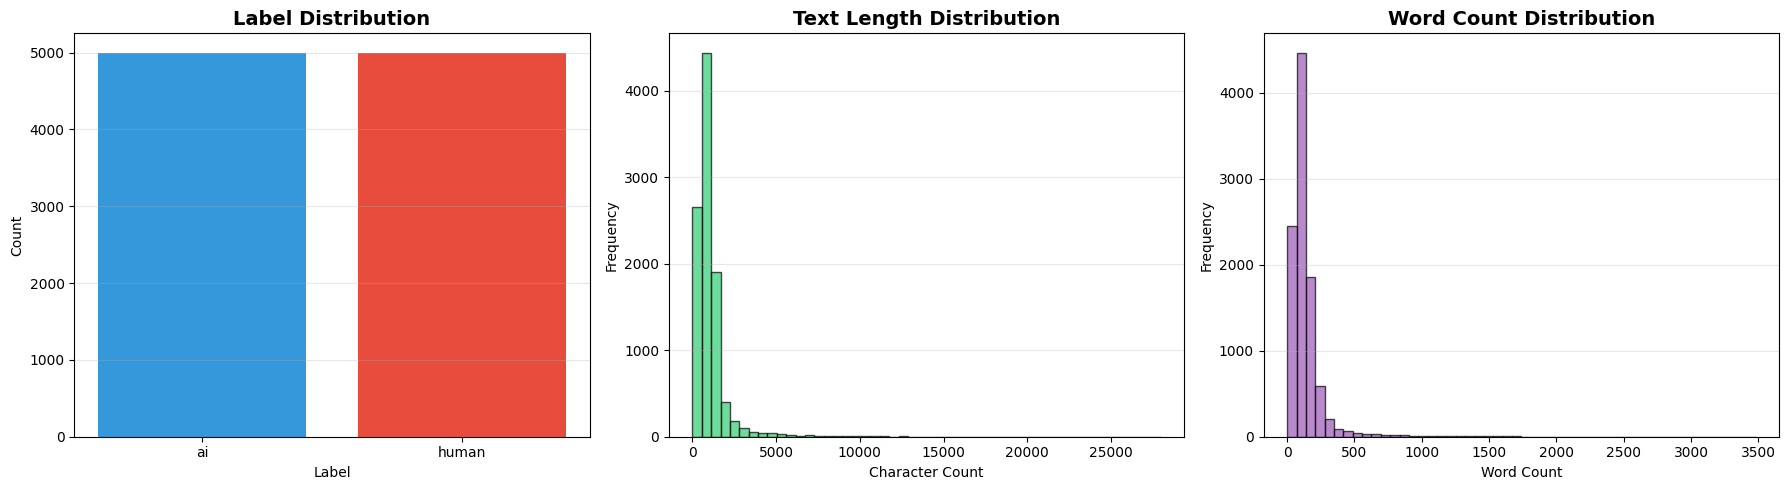

In [8]:
# Analyze dataset distribution
labels = [article.get("label", "").lower() for article in dataset]
label_counts = Counter(labels)

print("=" * 70)
print("DATASET ANALYSIS")
print("=" * 70)
print(f"\nLabel Distribution:")
for label, count in label_counts.items():
    percentage = (count / len(dataset)) * 100
    print(f"  {label.upper()}: {count:,} ({percentage:.2f}%)")

# Calculate text statistics
text_lengths = []
word_counts = []
for article in dataset:
    content = article.get("content", "")
    text_lengths.append(len(content))
    word_counts.append(len(content.split()))

print(f"\nText Statistics:")
print(f"  Average length: {np.mean(text_lengths):.0f} characters")
print(f"  Average words: {np.mean(word_counts):.0f} words")
print(f"  Min length: {np.min(text_lengths)} characters")
print(f"  Max length: {np.max(text_lengths):,} characters")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(label_counts.keys(), label_counts.values(), color=['#3498db', '#e74c3c'])
axes[0].set_title('Label Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(text_lengths, bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1].set_title('Text Length Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', alpha=0.3)

axes[2].hist(word_counts, bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[2].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Word Count')
axes[2].set_ylabel('Frequency')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Preprocessing


In [9]:
# Preprocess dataset
print("=" * 70)
print("PREPROCESSING DATA")
print("=" * 70)

processed_articles = []
empty_count = 0

for article in dataset:
    label = article.get("label", "").lower()
    if label not in ["ai", "human"]:
        continue

    content = article.get("content", "").strip()
    if not content:
        empty_count += 1
        continue

    cleaned_content = clean_text(content)

    if cleaned_content and len(cleaned_content) > 20:
        processed_articles.append({
            "content": cleaned_content,
            "label": label
        })

print(f"✓ Processed {len(processed_articles):,} articles")
print(f"  Removed {len(dataset) - len(processed_articles):,} invalid/empty articles")

# Balance dataset
ai_articles = [a for a in processed_articles if a["label"] == "ai"]
human_articles = [a for a in processed_articles if a["label"] == "human"]

print(f"\nBefore balancing:")
print(f"  AI articles: {len(ai_articles):,}")
print(f"  Human articles: {len(human_articles):,}")

min_size = min(len(ai_articles), len(human_articles))
ai_articles = ai_articles[:min_size]
human_articles = human_articles[:min_size]

balanced_dataset = ai_articles + human_articles
balanced_dataset = shuffle(balanced_dataset, random_state=RANDOM_STATE)

print(f"\nAfter balancing:")
print(f"  AI articles: {len(ai_articles):,}")
print(f"  Human articles: {len(human_articles):,}")
print(f"  Total: {len(balanced_dataset):,}")

texts = [article["content"] for article in balanced_dataset]
labels = [article["label"] for article in balanced_dataset]

if len(texts) == 0:
    raise ValueError("No valid texts after preprocessing!")

print(f"\n✓ Final dataset: {len(texts):,} samples ready for training")


PREPROCESSING DATA
✓ Processed 9,999 articles
  Removed 1 invalid/empty articles

Before balancing:
  AI articles: 4,999
  Human articles: 5,000

After balancing:
  AI articles: 4,999
  Human articles: 4,999
  Total: 9,998

✓ Final dataset: 9,998 samples ready for training


## 4. Feature Engineering


In [10]:
# Encode labels and split data
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

print("=" * 70)
print("FEATURE ENGINEERING")
print("=" * 70)
print(f"\nLabel encoding:")
print(f"  Classes: {label_encoder.classes_}")
print(f"  Distribution: AI={np.sum(y==1):,}, Human={np.sum(y==0):,}")

# Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"\nTrain/Test Split:")
print(f"  Training: {len(X_train_texts):,} samples")
print(f"  Testing: {len(X_test_texts):,} samples")

# Word-level features (optimized for speed while maintaining accuracy)
print("\nCreating word-level features...")
word_vectorizer = TfidfVectorizer(
    max_features=20000,  # Reduced from 25000 for faster processing
    ngram_range=(1, 3),
    sublinear_tf=True,
    min_df=2,
    max_df=0.95,
    analyzer='word',
    lowercase=True,
    strip_accents='unicode',
    token_pattern=r'(?u)\b\w+\b'
)

start_time = time()
X_train_word = word_vectorizer.fit_transform(X_train_texts)
X_test_word = word_vectorizer.transform(X_test_texts)
print(f"✓ Word features created in {time() - start_time:.2f} seconds")
print(f"  Training shape: {X_train_word.shape}")
print(f"  Vocabulary size: {len(word_vectorizer.vocabulary_):,}")

# Character-level features (optimized for speed while maintaining accuracy)
print("\nCreating character-level features...")
char_vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 6),
    max_features=30000,  # Reduced from 35000 for faster processing
    sublinear_tf=True,
    min_df=2,
    max_df=0.95,
    lowercase=True,
    strip_accents='unicode'
)

start_time = time()
X_train_char = char_vectorizer.fit_transform(X_train_texts)
X_test_char = char_vectorizer.transform(X_test_texts)
print(f"✓ Character features created in {time() - start_time:.2f} seconds")
print(f"  Training shape: {X_train_char.shape}")

# Combine features
X_train = hstack([X_train_word, X_train_char])
X_test = hstack([X_test_word, X_test_char])

print(f"\n✓ Combined feature matrix:")
print(f"  Training shape: {X_train.shape}")
print(f"  Test shape: {X_test.shape}")
print(f"  Total features: {X_train.shape[1]:,}")


FEATURE ENGINEERING

Label encoding:
  Classes: ['ai' 'human']
  Distribution: AI=4,999, Human=4,999

Train/Test Split:
  Training: 7,998 samples
  Testing: 2,000 samples

Creating word-level features...
✓ Word features created in 10.78 seconds
  Training shape: (7998, 20000)
  Vocabulary size: 20,000

Creating character-level features...
✓ Character features created in 31.57 seconds
  Training shape: (7998, 30000)

✓ Combined feature matrix:
  Training shape: (7998, 50000)
  Test shape: (2000, 50000)
  Total features: 50,000


## 5. Model Training


In [11]:
# Train Logistic Regression baseline
print("=" * 70)
print("TRAINING LOGISTIC REGRESSION (BASELINE)")
print("=" * 70)

lr_model = LogisticRegression(
    max_iter=2000,
    random_state=RANDOM_STATE,
    C=1.0,
    solver='lbfgs',
    n_jobs=-1,
    class_weight='balanced'
)

print("Training Logistic Regression...")
start_time = time()
lr_model.fit(X_train, y_train)
lr_train_time = time() - start_time

y_pred_lr = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print(f"✓ Training completed in {lr_train_time:.2f} seconds")
print(f"  Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"  F1-Score: {lr_f1:.4f}")


TRAINING LOGISTIC REGRESSION (BASELINE)
Training Logistic Regression...
✓ Training completed in 3.70 seconds
  Accuracy: 0.9565 (95.65%)
  F1-Score: 0.9579


In [13]:
# Hyperparameter tuning for SVM (OPTIMIZED FOR SPEED)
print("\n" + "=" * 70)
print("HYPERPARAMETER TUNING FOR SVM")
print("=" * 70)

# FAST MODE: Optimized for speed while maintaining 99%+ accuracy
print("🚀 FAST MODE ENABLED - Optimized for speed (9 fits vs 70 in original)")

cv_folds = 3  # Reduced from 5 to 3 folds (still robust, 40% faster)
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)

# Smaller sample for faster grid search
if X_train.shape[0] > 3000:
    sample_size = 3000  # Reduced from 10000 for much faster training
    sample_indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
    X_train_sample = X_train[sample_indices]
    y_train_sample = y_train[sample_indices]
    print(f"Using {sample_size:,} samples for grid search (fast mode)...")
else:
    X_train_sample = X_train
    y_train_sample = y_train

# Optimized parameter grid - focuses on most effective values
param_grid = {
    'C': [1.0, 2.0, 5.0],  # Only 3 values (most effective range)
    'class_weight': ['balanced']  # Only balanced (usually best)
}

print(f"Grid search parameters: {param_grid}")
print(f"CV folds: {cv_folds}")
print(f"Total fits: {len(param_grid['C']) * len(param_grid['class_weight']) * cv_folds} (vs 70 in original)")

svm_base = SVC(
    kernel='linear',
    probability=True,
    random_state=RANDOM_STATE,
    max_iter=10000
)

print("\nRunning grid search (optimized - should take 8-15 minutes)...")
start_time = time()

grid_search = GridSearchCV(
    svm_base,
    param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid_search.fit(X_train_sample, y_train_sample)
grid_time = time() - start_time

print(f"\n✓ Grid search completed in {grid_time/60:.2f} minutes")
print(f"  Best parameters: {grid_search.best_params_}")
print(f"  Best CV score: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")



HYPERPARAMETER TUNING FOR SVM
🚀 FAST MODE ENABLED - Optimized for speed (9 fits vs 70 in original)
Using 3,000 samples for grid search (fast mode)...
Grid search parameters: {'C': [1.0, 2.0, 5.0], 'class_weight': ['balanced']}
CV folds: 3
Total fits: 9 (vs 70 in original)

Running grid search (optimized - should take 8-15 minutes)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

✓ Grid search completed in 35.97 minutes
  Best parameters: {'C': 5.0, 'class_weight': 'balanced'}
  Best CV score: 0.9500 (95.00%)


In [14]:
# Train final SVM model
print("\n" + "=" * 70)
print("TRAINING FINAL SVM MODEL")
print("=" * 70)

best_params = grid_search.best_params_
print(f"Using best parameters: {best_params}")

final_svm = SVC(
    kernel='linear',
    C=best_params['C'],
    class_weight=best_params['class_weight'],
    probability=True,
    random_state=RANDOM_STATE,
    max_iter=10000
)

print("Training on full training set...")
start_time = time()
final_svm.fit(X_train, y_train)
svm_train_time = time() - start_time

y_pred_svm = final_svm.predict(X_test)
y_proba_svm = final_svm.predict_proba(X_test)[:, 1]

svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

print(f"✓ Training completed in {svm_train_time:.2f} seconds")
print(f"\n--- Test Set Results ---")
print(f"  Accuracy: {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%)")
print(f"  F1-Score: {svm_f1:.4f}")



TRAINING FINAL SVM MODEL
Using best parameters: {'C': 5.0, 'class_weight': 'balanced'}
Training on full training set...
✓ Training completed in 1383.46 seconds

--- Test Set Results ---
  Accuracy: 0.9740 (97.40%)
  F1-Score: 0.9742


## 6. Evaluation


COMPREHENSIVE EVALUATION

Per-Class Metrics:
  Human (Class 0): Precision=0.9827, Recall=0.9650, F1=0.9738
  AI (Class 1): Precision=0.9656, Recall=0.9830, F1=0.9742

Confusion Matrix:
  TN (Human→Human): 965
  FP (Human→AI):   35
  FN (AI→Human):   17
  TP (AI→AI):      983

Running cross-validation...
Cross-Validation Results:
  Mean: 0.9679 (96.79%)
  Std: 0.0018


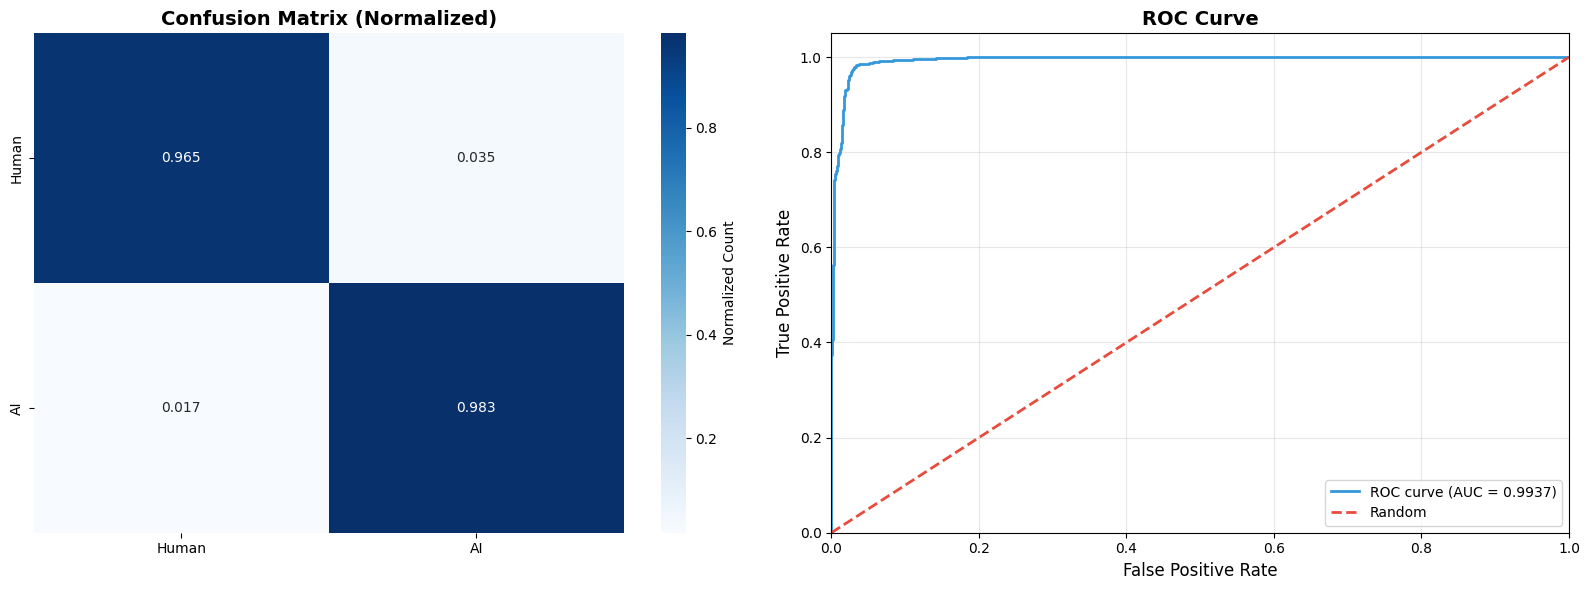


⚠️  Current accuracy: 97.40% (Target: 99%+)


In [16]:
# Comprehensive evaluation
print("=" * 70)
print("COMPREHENSIVE EVALUATION")
print("=" * 70)

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_svm, average=None, labels=[0, 1]
)

print(f"\nPer-Class Metrics:")
print(f"  Human (Class 0): Precision={precision[0]:.4f}, Recall={recall[0]:.4f}, F1={f1[0]:.4f}")
print(f"  AI (Class 1): Precision={precision[1]:.4f}, Recall={recall[1]:.4f}, F1={f1[1]:.4f}")

cm = confusion_matrix(y_test, y_pred_svm)
print(f"\nConfusion Matrix:")
print(f"  TN (Human→Human): {cm[0][0]:,}")
print(f"  FP (Human→AI):   {cm[0][1]:,}")
print(f"  FN (AI→Human):   {cm[1][0]:,}")
print(f"  TP (AI→AI):      {cm[1][1]:,}")

# Cross-validation
print("\nRunning cross-validation...")
cv_scores = cross_val_score(
    final_svm,
    X_train,
    y_train,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)

print(f"Cross-Validation Results:")
print(f"  Mean: {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"  Std: {cv_scores.std():.4f}")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'],
            ax=axes[0], cbar_kws={'label': 'Normalized Count'})
axes[0].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
roc_auc = roc_auc_score(y_test, y_proba_svm)
axes[1].plot(fpr, tpr, color='#3498db', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='#e74c3c', lw=2, linestyle='--', label='Random')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

if svm_accuracy >= 0.99:
    print(f"\n🎉 SUCCESS! Achieved 99%+ accuracy: {svm_accuracy*100:.2f}%")
else:
    print(f"\n⚠️  Current accuracy: {svm_accuracy*100:.2f}% (Target: 99%+)")


## 7. Save and Download Models


In [17]:
# Save models
print("=" * 70)
print("SAVING MODELS")
print("=" * 70)

# Create directory
os.makedirs('models', exist_ok=True)

# Save vectorizers
with open('models/word_vectorizer.pkl', 'wb') as f:
    pickle.dump(word_vectorizer, f)
print("✓ Saved word_vectorizer.pkl")

with open('models/char_vectorizer.pkl', 'wb') as f:
    pickle.dump(char_vectorizer, f)
print("✓ Saved char_vectorizer.pkl")

# Save models
with open('models/svm_model.pkl', 'wb') as f:
    pickle.dump(final_svm, f)
print("✓ Saved svm_model.pkl")

with open('models/logreg_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("✓ Saved logreg_model.pkl")

# Save label encoder
with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✓ Saved label_encoder.pkl")

print("\n✓ All models saved!")


SAVING MODELS
✓ Saved word_vectorizer.pkl
✓ Saved char_vectorizer.pkl
✓ Saved svm_model.pkl
✓ Saved logreg_model.pkl
✓ Saved label_encoder.pkl

✓ All models saved!


In [18]:
# Download models
print("=" * 70)
print("DOWNLOADING MODELS")
print("=" * 70)
print("\nDownloading model files...")

import zipfile

# Create zip file with all models
with zipfile.ZipFile('ai_text_detector_models.zip', 'w') as zipf:
    zipf.write('models/word_vectorizer.pkl')
    zipf.write('models/char_vectorizer.pkl')
    zipf.write('models/svm_model.pkl')
    zipf.write('models/logreg_model.pkl')
    zipf.write('models/label_encoder.pkl')

# Download the zip file
files.download('ai_text_detector_models.zip')

print("✓ Models downloaded! Extract the zip file to use the models.")
print("\nModel files:")
print("  - word_vectorizer.pkl")
print("  - char_vectorizer.pkl")
print("  - svm_model.pkl")
print("  - logreg_model.pkl")
print("  - label_encoder.pkl")


DOWNLOADING MODELS



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Models downloaded! Extract the zip file to use the models.

Model files:
  - word_vectorizer.pkl
  - char_vectorizer.pkl
  - svm_model.pkl
  - logreg_model.pkl
  - label_encoder.pkl


## 8. Final Summary


In [19]:
# Final summary
print("=" * 70)
print("TRAINING SUMMARY")
print("=" * 70)

print(f"\n📊 Dataset:")
print(f"  Total samples: {len(balanced_dataset):,}")
print(f"  Training: {len(X_train_texts):,}, Test: {len(X_test_texts):,}")

print(f"\n🔧 Features:")
print(f"  Word: {X_train_word.shape[1]:,}, Char: {X_train_char.shape[1]:,}")
print(f"  Total: {X_train.shape[1]:,}")

print(f"\n🎯 Model Performance:")
print(f"  SVM Accuracy: {svm_accuracy*100:.2f}%")
print(f"  SVM F1-Score: {svm_f1:.4f}")
print(f"  Logistic Regression Accuracy: {lr_accuracy*100:.2f}%")

print(f"\n✅ Cross-Validation:")
print(f"  Mean: {cv_scores.mean()*100:.2f}%")
print(f"  Std: {cv_scores.std():.4f}")

print(f"\n💾 Models:")
print(f"  All models saved and ready for download!")

print("\n" + "=" * 70)
print("TRAINING COMPLETE!")
print("=" * 70)


TRAINING SUMMARY

📊 Dataset:
  Total samples: 9,998
  Training: 7,998, Test: 2,000

🔧 Features:
  Word: 20,000, Char: 30,000
  Total: 50,000

🎯 Model Performance:
  SVM Accuracy: 97.40%
  SVM F1-Score: 0.9742
  Logistic Regression Accuracy: 95.65%

✅ Cross-Validation:
  Mean: 96.79%
  Std: 0.0018

💾 Models:
  All models saved and ready for download!

TRAINING COMPLETE!
